**SUPER DENSE CODING**

The process starts with a third party, who we'll call Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state  
|
0
⟩
 . He applies Hadamard gate ( 
H
 ) to the first qubit to create superposition. He then applies CNOT gate ( 
C
X
 ) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mentioned earlier.



Charlie sends the first qubit to Alice and the second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send:

For 00-> I
For 01-> X
For 10-> Z
For 11->ZX

Bob receives Alice's qubit (leftmost qubit) and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state in order to decode it — he simply uses the restoration operation.

Bob applies a CNOT gate using the leftmost qubit as control and the rightmost as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.

In [1]:
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [2]:
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1, 0)
    return qc

In [3]:
def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set([0,1]).issubset({0,1}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

In [4]:
def decode_message(qc):
    qc.cx(1, 0)
    qc.h(1)
    return qc

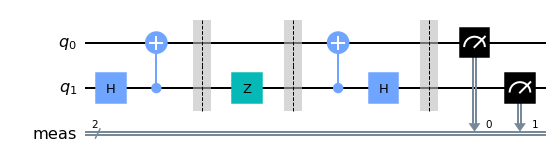

In [5]:
# Charlie creates the entangled pair between Alice and Bob
qc = create_bell_pair()

# We'll add a barrier for visual separation
qc.barrier()

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 1. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = '10'
qc = encode_message(qc, 1, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
qc = decode_message(qc)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

{'10': 1024}


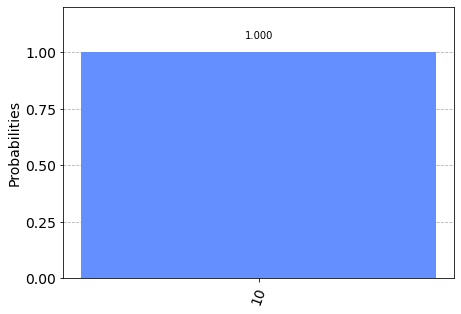

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

**Superdense Coding on a Real Quantum Computer**

In [7]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

least busy backend:  ibmq_quito


In [8]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


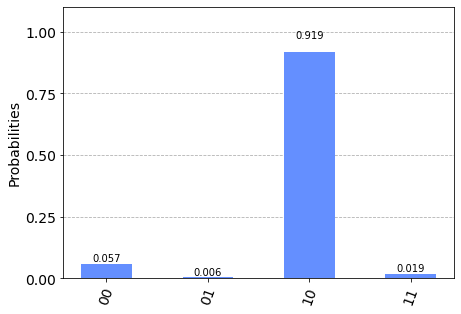

In [9]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

In [10]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

Accuracy = 358.89%


In [11]:
import qiskit.tools.jupyter
%qiskit_version_table